In [1]:
import gym
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.distributions import Categorical
import matplotlib.pyplot as plt

In [2]:
# Policy Network
class Actor(nn.Module):
    def __init__(self, n_actions, state_size):
        super(Actor, self).__init__()
        self.hidden = nn.Linear(state_size, 16)
        self.logits = nn.Linear(16, n_actions)
        
    def forward(self, state):
        x = F.relu(self.hidden(torch.FloatTensor(state)))
        x = F.softmax(self.logits(x), dim=-1)
        return x

In [3]:
# Q Network
class Critic(nn.Module):
    def __init__(self, state_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size, 16) 
        self.fc2 = nn.Linear(16, 8)
        self.q_value = nn.Linear(8, 1)
        
    def forward(self, state):
        x = F.relu(self.fc1(torch.FloatTensor(state)))
        x = F.relu(self.fc2(x))
        x = self.q_value(x)
        return x

In [4]:
class A2C():
    def __init__(self):
        self.env = gym.make('CartPole-v1')
        self.n_actions = self.env.action_space.n
        self.state_size = self.env.observation_space.shape[0]
        self.actor = Actor(self.n_actions, self.state_size) 
        self.actor_optim = Adam(params=self.actor.parameters(), lr=1e-3)
        self.critic = Critic(self.state_size) 
        self.critic_optim = Adam(params=self.critic.parameters(), lr=2e-3)
    
    def get_action(self, state):
        action_probs = self.actor(state)
        distro = Categorical(action_probs)
        return distro.sample().item()
    
    def advantage(self, state, action, reward, next_state, done, gamma=0.975):
        return reward + (1 - done) * gamma * self.critic(next_state) - self.critic(state) 
    
    # actor loss == TD Policy Gradient loss
    # critic loss == Q Learning loss
    def loss(self, advantage, state, action):
        self.actor_optim.zero_grad()
        action_probs = self.actor(state)
        dist = Categorical(action_probs)
        actor_loss = -dist.log_prob(torch.tensor(action)) * advantage
        actor_loss.backward(retain_graph=True)
        self.actor_optim.step()
        
        self.critic_optim.zero_grad()
        critic_loss = advantage ** 2
        critic_loss.backward()
        self.critic_optim.step()
        
    def learn(self):
        returns = []
        mean_return = []
        episode_len = 500
        solved = False
        for episode in range(episode_len):
            done = False
            state = self.env.reset()
            rewards = []
            while not done:
                action = self.get_action(state)
                next_state, reward, done, _ = self.env.step(action)
                advantage = self.advantage(state, action, reward, next_state, done)
                self.loss(advantage, state, action)

                rewards.append(reward)
                state = next_state
            
            returns.append(np.sum(rewards))
            mean_return.append(np.mean(returns[-100:]))
            if mean_return[-1] >= 195.0 and not solved:
                print(f'Solved CartPole in {episode} episodes :)')
                solved = True
                break
            elif episode + 1 == episode_len:
                print('You failed.')
                
        return returns, mean_return

    def plot(self, returns, mean_return):
        plt.plot(returns, label='Episodic Return')
        plt.plot(mean_return, label='Mean Return')
        plt.title('A2C Training Curve')
        plt.legend()
        plt.xlabel('Episodes')
        plt.ylabel('Total Return')
        plt.show()

Solved CartPole in 400 episodes :)


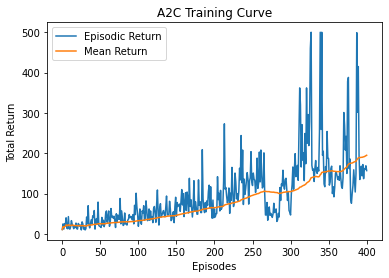

In [5]:
if __name__ == '__main__':
    a2c = A2C()
    returns, mean_return = a2c.learn()
    a2c.plot(returns, mean_return)